In [1]:
# Import packages
import pandas as pd
import numpy as np
import math
import time

from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

from hyperopt import *
import pyspark 
import mlflow

import seaborn as sns

import warnings

In [2]:
# Import Data
train = pd.read_csv("..\\Predictive Models\\Datasets\\17SMOTE_0.75_newlabel.csv", delimiter=',')
test = pd.read_csv("..\\Predictive Models\\Datasets\\172_newlabel.csv", delimiter=',')
validation = pd.read_csv("..\\Data\\final_18_new.csv", delimiter=',')
validation2 = pd.read_csv("..\\Data\\final_19_new.csv", delimiter=',')

# Define X and y
X_train = (train.drop(labels=["label"], axis=1))
y_train = train[["label"]]
X_test = test.drop(labels=["label","c28992r100","row","column","WONING"], axis=1)
y_test =test[["label"]]

X_val1 = validation.drop(labels=["label","c28992r100","row","column","WONING"], axis=1)
y_val1 = validation[["label"]]
X_val2 = validation2.drop(labels=["label","c28992r100","row","column","WONING"], axis=1)
y_val2 = validation2[["label"]]

# Make column list
columns = X_train.columns

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# Define hyperopt settings

In [3]:
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()
# Define objectives
def objective(params):
    classifier_type = params['type']
    del params['type']
    if classifier_type == 'svc':
        clf = SVC(**params,
                  probability=True,
                 max_iter = 500)
    else:
        return 0
    classifier = clf
    print(classifier)
    classifier.fit(X_train, y_train)
    pr_svc = classifier.predict(X_train)
    accuracy = accuracy_score(y_train,pr_svc)
    f1 = f1_score(y_train,pr_svc)
    recall = recall_score(y_train,pr_svc)
    print(accuracy, f1, recall)

    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define search space
space = hp.choice('classifier_type', [
        {
            "type": 'svc',
            'C':hp.choice('C',np.logspace(-3, 3, num=7)),
           'kernel':hp.choice('kernel',["linear","poly","rbf","sigmoid"]),
           'degree':hp.choice('degree',range(1,10,1)),
           'gamma':hp.choice('gamma',np.logspace(-3, 3, num=7)),
            'coef0':hp.choice('coef0',np.logspace(-3, 3, num=7))}
])
    
with mlflow.start_run():
    best = fmin(
    fn=objective, 
    space=space,
    algo=tpe.suggest,
    max_evals=30, 
    verbose = 1,
    return_argmin=False)
    
    
print("--- %s seconds ---" % (time.time() - start_time))

SVC(coef0=0.01, degree=5, gamma=0.1, max_iter=500, probability=True)                                                   
0.4292021832208568                                                                                                     
0.5991771278080482                                                                                                     
0.9954789523813485                                                                                                     
SVC(coef0=0.01, degree=6, gamma=1.0, kernel='linear', max_iter=500,                                                    
    probability=True)
0.4389614371325797                                                                                                     
0.590382488059449                                                                                                      
0.943397482021869                                                                                                      
SVC(C=10.0, coef0=

0.5999997504482574                                                                                                     
1.0                                                                                                                    
SVC(C=1000.0, coef0=1.0, degree=4, gamma=0.1, kernel='poly', max_iter=500,                                             
    probability=True)
0.4457920236147207                                                                                                     
0.5774591612079041                                                                                                     
0.8836339739883792                                                                                                     
SVC(C=1000.0, coef0=0.1, degree=7, gamma=100.0, kernel='poly', max_iter=500,                                           
    probability=True)
0.4285711739268386                                                                                                  

In [4]:
# Results
print(best)

{'C': 0.1, 'coef0': 10.0, 'degree': 9, 'gamma': 0.001, 'kernel': 'rbf', 'type': 'svc'}


In [5]:
# Fitting Randomforest to the Training set
classifier = SVC(C = best['C'],
                 kernel = best['kernel'],
                 degree = best['degree'],
                 gamma = best['gamma'], 
                 coef0 = best['coef0'], 
                 probability=True,
                max_iter = 500)
classifier.fit(X_train, y_train)
pr_svm = classifier.predict(X_train)
accuracy = accuracy_score(y_train,pr_svm)
f1 = f1_score(y_train,pr_svm)
recall = recall_score(y_train,pr_svm)
print(accuracy, f1, recall)
print(roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1]))

0.5801007475855873 0.039932508436445434 0.020375908264741234
0.518754842868967


# Results

Accuracy:0.9619251510799165
F1:0.004252303330970943
Recall:0.0021994134897360706


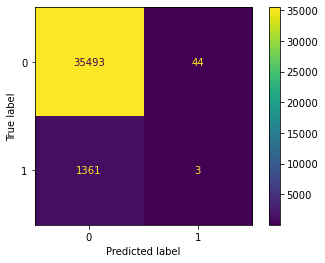

Accuracy:0.9655817241788724
F1:0.0014092225788773192
Recall:0.0007172457762193178


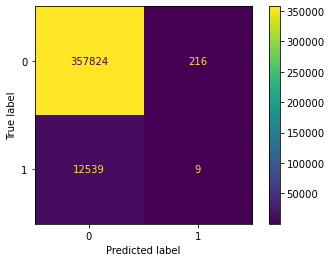

Accuracy:0.9791496452375833
F1:0.0
Recall:0.0


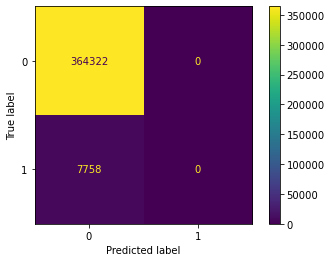

In [6]:
# Make confusion matrixes, accuracy, recall and f1 score for testset
p_svm = classifier.predict(X_test)
print("Accuracy:" + str(classifier.score(X_test, y_test)))
print("F1:" + str(f1_score(y_test,p_svm)))
print("Recall:" + str(recall_score(y_test,p_svm)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,p_svm),display_labels=classifier.classes_).plot()
plt.savefig('con_test_svm_smote0.75.png', dpi=300)
plt.show()

# Make confusion matrixes, accuracy, recall and f1 score for validationset 1
pre_svm = classifier.predict(X_val1)
print("Accuracy:" + str(classifier.score(X_val1, y_val1)))
print("F1:" + str(f1_score(y_val1,pre_svm)))
print("Recall:" + str(recall_score(y_val1,pre_svm)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val1,pre_svm),display_labels=classifier.classes_).plot()
plt.savefig('con_val_svm_smote0.75.png', dpi=300)
plt.show()

# Make confusion matrixes, accuracy, recall and f1 score for validationset 2
pred_svm = classifier.predict(X_val2)
print("Accuracy:" + str(classifier.score(X_val2, y_val2)))
print("F1:" + str(f1_score(y_val2, pred_svm)))
print("Recall:" + str(recall_score(y_val2, pred_svm)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val2, pred_svm),display_labels=classifier.classes_).plot()
plt.savefig('con_val2_svm_smote0.75.png', dpi=300)
plt.show()

In [7]:
print(roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_val1, classifier.predict_proba(X_val1)[:, 1]))
print(roc_auc_score(y_val2, classifier.predict_proba(X_val2)[:, 1]))

0.5059506254148232
0.5015976071169471
0.5


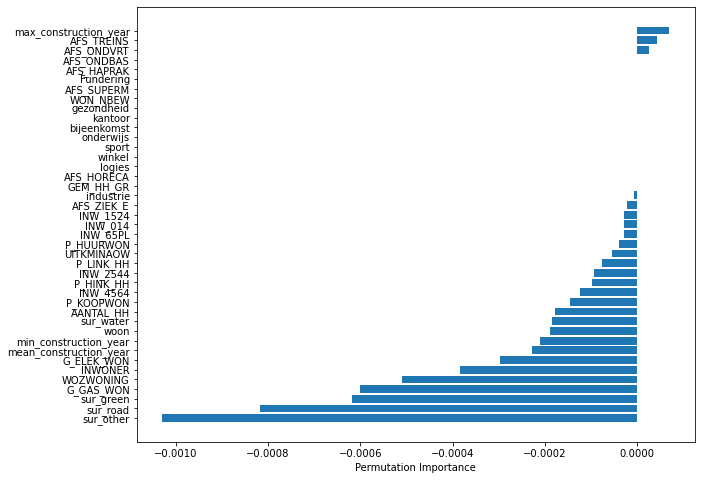

In [8]:
# Create feature importance plot
perm_importance = permutation_importance(classifier, X_test, y_test)

feature_names = columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,8)) 
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig('import_svm_smote0.75.png', dpi=300, bbox_inches = "tight")

# Make QGIS File

In [9]:
# Create Dataframe with TP, TN, FP, FN and gridnumber
qgis_koppel_train = []
qgis_koppel_test = []
qgis_koppel_val1 = []
qgis_koppel_val2 = []
qgis_train = pd.DataFrame(train.index,columns=["id"])
qgis_test = pd.DataFrame(test.index,columns=["id"])
qgis_val1 = pd.DataFrame(validation["c28992r100"],columns=["c28992r100"])
qgis_val2 = pd.DataFrame(validation2["c28992r100"],columns=["c28992r100"])

for y, yt in zip(y_train, pr_svm):
    if y == 0 and yt == 0:
        qgis_koppel_train.append("TN")
    if y == 0 and yt == 1:
        qgis_koppel_train.append("FN")
    if y == 1 and yt == 0:
        qgis_koppel_train.append("FP")
    if y == 1 and yt == 1:
        qgis_koppel_train.append("TP")

for y, yt in zip(y_test.to_numpy(), p_svm):
    if y == 0 and yt == 0:
        qgis_koppel_test.append("TN")
    if y == 0 and yt == 1:
        qgis_koppel_test.append("FN")
    if y == 1 and yt == 0:
        qgis_koppel_test.append("FP")
    if y == 1 and yt == 1:
        qgis_koppel_test.append("TP")
        
for y, yt in zip(y_val1.to_numpy(), pre_svm):
    if y == 0 and yt == 0:
        qgis_koppel_val1.append("TN")
    if y == 0 and yt == 1:
        qgis_koppel_val1.append("FN")
    if y == 1 and yt == 0:
        qgis_koppel_val1.append("FP")
    if y == 1 and yt == 1:
        qgis_koppel_val1.append("TP")

for y, yt in zip(y_val2.to_numpy(), pred_svm):
    if y == 0 and yt == 0:
        qgis_koppel_val2.append("TN")
    if y == 0 and yt == 1:
        qgis_koppel_val2.append("FN")
    if y == 1 and yt == 0:
        qgis_koppel_val2.append("FP")
    if y == 1 and yt == 1:
        qgis_koppel_val2.append("TP")

qgis_train["label"] = pd.Series(qgis_koppel_train)
qgis_test["label"] = pd.Series(qgis_koppel_test)
qgis_val1["label"] = pd.Series(qgis_koppel_val1)
qgis_val2["label"] = pd.Series(qgis_koppel_val2)

qgis_train.to_csv("qgistrainsvmS75.csv", index=False)
qgis_test.to_csv("qgistestsvmS75.csv", index=False)
qgis_val1.to_csv("qgisval1svmS75.csv", index=False)
qgis_val2.to_csv("qgisval2svmS75.csv", index=False)